### Load HDX-MS experiment data file ###

In [1]:
from pyhdx import read_dynamx, HDXMeasurement
from pyhdx.plot import peptide_coverage
from pyhdx.process import correct_d_uptake, filter_peptides, apply_control
from pyhdx.models import Coverage
from pyhdx.config import cfg
from pyhdx.fitting import fit_d_uptake
from pyhdx.fileIO import csv_to_hdxm, csv_to_dataframe

import proplot as pplt
import pandas as pd
import numpy as np
import os   
from pathlib import Path
import pickle
from typing import Union, Literal, IO, Optional

import matplotlib.pyplot as pplt
import seaborn as sns

root_dir = f'/home/lwang/models/HDX_LSTM/data/Latest_set'
hdx_dir = f'{root_dir}/HDX_files/'
pdb_dir = f'{root_dir}/structure/'
hdxm_dir = f'{root_dir}/HDX_files/hdxm_files'

/home/lwang/models/mambaforge/envs/pyhdx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
root_dir = f'/home/lwang/models/HDX_LSTM/data/Latest_set'
hdx_dir = f'{root_dir}/HDX_files/'
pdb_dir = f'{root_dir}/structure/'
hdxm_dir = f'{root_dir}/HDX_files/hdxm_files'

summary_df = pd.read_excel(f'/home/lwang/models/HDX_LSTM/data/Latest_set/merged_data-NAcomplex.xlsx', sheet_name='Sheet1')
summary_df = summary_df[summary_df['complex_state'].isin(['single', 'protein complex'])]
summary_df = summary_df.dropna(subset=['structure_file'])
summary_df = summary_df[summary_df['database_id'] != 'PXD041774'] # remove LptDEM
#summary_df = summary_df.drop_duplicates(subset=['structure_file'])
print('Load summary file:', summary_df.shape)

# file check
print('Starting file check: HDX-MS and PDB files')
for i, row in summary_df.iterrows():
    protein = row['protein']
    state = row['state']
    pdb_file = row['structure_file'].upper()
    database_id = row['database_id']

    if not os.path.exists(f'{hdx_dir}/{database_id}_revised.xlsx') or not os.path.exists(f'{pdb_dir}/{pdb_file}.pdb'):
        print('missing HDX file or PDB file:', database_id, protein, state)
        summary_df.drop(i, inplace=True)
        continue
    hdx_df = pd.read_excel(f'{hdx_dir}/{database_id}_revised.xlsx', sheet_name='Sheet1')
    hdx_df = hdx_df[(hdx_df['protein'] == protein) & (hdx_df['state'] == state)]
    hdx_df = hdx_df[(hdx_df['log_t']>=1.35) & (hdx_df['log_t']<2.85)] # HDX middle exposure range
    if hdx_df.empty:
        summary_df.drop(i, inplace=True)
        print('Cannot find protein/state data in HDX-MS file:', database_id, protein, state)
        continue
print('Trimming the unfound data:', summary_df.shape)

Load summary file: (178, 24)
Starting file check: HDX-MS and PDB files
Cannot find protein/state data in HDX-MS file: PXD019199 P672 Complex
Cannot find protein/state data in HDX-MS file: PXD032837 Rab11 Phosphorylated Complex
Cannot find protein/state data in HDX-MS file: PXD032837 Rab11 Unphosphorylated Complex
Cannot find protein/state data in HDX-MS file: PXD032837 WDR44 Apo
Cannot find protein/state data in HDX-MS file: PXD032837 WDR44 Phosphorylated Complex
Cannot find protein/state data in HDX-MS file: PXD032837 WDR44 Unphosphorylated Complex
Cannot find protein/state data in HDX-MS file: PXD032929 Akt1-1P Apo
Cannot find protein/state data in HDX-MS file: PXD032929 Akt1-3P AKT3P Apo
Trimming the unfound data: (170, 24)


In [6]:
# functions

def read_HDXdata(
    filepath_or_buffer: Union[Path[str], str, IO], protein, state
) -> pd.DataFrame:
    df = pd.read_excel(filepath_or_buffer, sheet_name="Sheet1")
    df['exposure'] = round(10 ** df['log_t'])
    df = df[(df['protein'] == protein) & (df['state'] == state)]
    df = df[(df['log_t']>=1.35) & (df['log_t']<2.85)] # HDX middle exposure range
    df = df[df['start'] > 0]
    fpath = filepath_or_buffer.split('.')[0]+'.csv'
    df.to_csv(fpath, index=False)
    return read_dynamx(fpath)

def simulate_FullD(df, D_conc, back_Ex=0.7):
    # input df should contain single protein and state
    # simulated Uptake(FD control) = back_Ex * D_conc * N(exchangeable residues), we assume back_Ex = 0.7 when not provided
    FD_df = df.copy()
    FD_df = FD_df.drop_duplicates(subset=['sequence'])
    FD_df['state'] = 'Full deuteration control'
    FD_df['N_ExRes'] = FD_df['sequence'].apply(count_ExRes)
    FD_df['uptake'] = back_Ex * D_conc * FD_df['N_ExRes']
    print(FD_df['uptake'].isna().sum())
    FD_df['uptake_sd'] = 0.0
    return FD_df

def count_ExRes(seq):
    # count exchangeable residues in a sequence
    seq = seq.upper()
    if seq[0] == 'P':
        return len(seq.replace('P', ''))
    else:
        return len(seq.replace('P', '')) - 1

def recover_seq(df):
    df = df.sort_values(by=['start', 'end'])
    df = df.drop_duplicates(subset=['sequence'])
    df = df[df['start'] > 0]
    length = df['end'].max()
    reCon_seq = 'x' * length
    pop_list = []
    for i, row in df.iterrows():
        start, end = row['start'], row['end']
        segment = row['sequence']
        if len(segment) != (end-start+1):
            print('Error: segment length does not match start/end:', start, end, segment)
            pop_list.append(i)
            continue
        reCon_seq = reCon_seq[:start-1] + row['sequence'] + reCon_seq[end:]
    return reCon_seq, pop_list

In [64]:
### create and save HDXMeasurement object
hdxm_dir = f'{root_dir}/HDX_files/hdxm_files'
fail_list = []
for i, row in summary_df.iterrows():
    if os.path.exists(f'{hdxm_dir}/{i}.csv'):
        continue
    skip = [27, 33, 34, 86, 117, 167, 168, 169, 170, 171, 172, 313]
    if i in skip:
        continue

    protein = row['protein']
    state = row['state']
    pdb_file = row['structure_file'].upper()
    database_id = row['database_id']
    D_conc = row['D_Conc']
    print('Processing:', database_id, protein, state, i)

    #try:
    # correct rfu value
    data = read_HDXdata(f'{hdx_dir}/{database_id}_revised.xlsx', protein, state)
    data['uptake_sd'] = 0.00
    FD_control = simulate_FullD(data, D_conc=D_conc, back_Ex=0.7)

    # group data
    cols = ['database_id', 'protein', 'state', 'start', 'end', 'stop', 'sequence', 'maxd']
    mean_data = data.groupby(cols, as_index=False).mean()
    if 'uptake' not in mean_data.columns:
        mean_data = pd.merge(mean_data, FD_control[['sequence', 'uptake']], on='sequence', how='left')
        mean_data['uptake'] = mean_data['uptake'] * mean_data['rfu'] / 100

    peptides_control = apply_control(mean_data, FD_control, nd_control=None)# ERROR
    peptides_corrected = correct_d_uptake(peptides_control, drop_first=1, d_percentage=100)

    # create HDX Measurement object
    sequence, pop_list = recover_seq(mean_data) # pop out mismatch segments
    mean_data = mean_data.drop(pop_list)

    temp, pH = row['temp'], row['pH']
    pH = 7.4 if pH=='nk' else pH
    temp = 25 if temp=='rt' else temp
    
    hdxm = HDXMeasurement(peptides_corrected, sequence=sequence, name = f'{protein}_{state}') # Error: providing temperature and pH will allow calculation of kint theoretical rate constants
    hdxm.to_file(f'{hdxm_dir}/{i}.csv')
    #break
    '''except Exception as e:
        print('Failed to create HDXMeasurement object:', database_id, protein, state, i)
        print(e)
        fail_list.append((database_id, protein, state))
        break'''
print('Failed list:', fail_list)

Failed list: []


In [28]:
# get residue-wise HDX uptake 

save_dir = f'{root_dir}/HDX_files/res_D_fit'
save_fail = []
for file in os.listdir(hdxm_dir):
    file_id = int(file.split('.')[0])    
    if os.path.exists(f'{save_dir}/{file_id}.pkl'):
        continue
    
    try:
        df = csv_to_dataframe(f'{hdxm_dir}/{file}')
        sequence = df.attrs["metadata"]['sequence']
        hdxm = csv_to_hdxm(f'{hdxm_dir}/{file}')
        print(hdxm.coverage.interval)
        hdx_t = hdxm[1]
        b = hdx_t.data["uptake_corrected"].values
        X_inv = np.linalg.pinv(hdx_t.X)
        d_inv = X_inv.dot(b)
        # Remove parts which do not exchange (prolines, coverage gaps)
        d_inv[~hdx_t["exchanges"]] = np.nan
        break
        #fit_1 = fit_d_uptake(hdxm, r1=1.0, repeats=20)
        '''result = (sequence, fit_1.result)

        with open(f'{save_dir}/{file_id}.pkl', 'wb') as f:
            pickle.dump(result, f)'''
    except Exception as e:
        print(f'Failed in file{file_id}:', e)
        save_fail.append(file)
        continue
print('Failed list:', save_fail)

(2, 353)
Failed list: []


In [15]:
# get average Residue-wise HDX uptake and match with sequence

root_dir = f'/home/lwang/models/HDX_LSTM/data/Latest_set'
save_dir = f'{root_dir}/HDX_files/res_D_fit'
hdxm_dir = f'{root_dir}/HDX_files/hdxm_files'

fail_list = []
for file in os.listdir(save_dir):
    print('Processing:', file)
    file_id = int(file.split('.')[0])
    '''if os.path.exists(f'{root_dir}/HDX_files/res_D_fit_mean/{file_id}.pkl'):
        continue'''
    #try:
    df = csv_to_dataframe(f'{hdxm_dir}/{file_id}.csv')
    sequence = df.attrs["metadata"]['sequence']
    hdxm = csv_to_hdxm(f'{hdxm_dir}/{file_id}.csv')
    cover_start, cover_end = hdxm.coverage.interval

    with open(f'{save_dir}/{file}', 'rb') as f:
        result = pickle.load(f) # (sequence, fit_1.result)

    resD_fit = result[1]
    if resD_fit.ndim == 2:
        resD_fit = resD_fit.reshape((1, resD_fit.shape[0], resD_fit.shape[1]))
    resD_fit = resD_fit.mean(axis=(0,1))
    res_D_dict = {}
    
    count = 0
    for i in range(cover_start, len(sequence)-1):
        res = sequence[i+1]
        if res != 'x':
            res_D_dict[i] = resD_fit[count]
            count += 1
        else:
            res_D_dict[i] = np.nan

    with open(f'{root_dir}/HDX_files/res_D_fit_mean/{file_id}.pkl', 'wb') as f:
        pickle.dump(res_D_dict, f)
    '''except Exception as e:
        print(f'Failed in file{file_id}:', e)
        fail_list.append(file)
        continue'''
print('Failed list:', fail_list)

Processing: 228.pkl
Processing: 0.pkl
Processing: 1.pkl
Processing: 2.pkl
Processing: 229.pkl
Processing: 3.pkl
Processing: 4.pkl
Processing: 5.pkl
Processing: 6.pkl
Processing: 7.pkl
Processing: 8.pkl
Processing: 9.pkl
Processing: 10.pkl
Processing: 11.pkl
Processing: 14.pkl
Processing: 17.pkl
Processing: 18.pkl
Processing: 19.pkl
Processing: 22.pkl
Processing: 23.pkl
Processing: 41.pkl
Processing: 42.pkl
Processing: 43.pkl
Processing: 44.pkl
Processing: 45.pkl
Processing: 46.pkl
Processing: 47.pkl
Processing: 48.pkl
Processing: 49.pkl
Processing: 50.pkl
Processing: 51.pkl
Processing: 52.pkl
Processing: 53.pkl
Processing: 54.pkl
Processing: 55.pkl
Processing: 56.pkl
Processing: 57.pkl
Processing: 58.pkl
Processing: 59.pkl
Processing: 60.pkl
Processing: 61.pkl
Processing: 65.pkl
Processing: 68.pkl
Processing: 71.pkl
Processing: 73.pkl
Processing: 77.pkl
Processing: 78.pkl
Processing: 79.pkl
Processing: 80.pkl
Processing: 83.pkl
Processing: 93.pkl
Processing: 95.pkl
Processing: 101.pkl


Missing HDX file: PXD032837
Missing HDX file: PXD032929
4665 4665
41.069349040451165 24.663032793536548
13.255734190782423 6.25992732033042


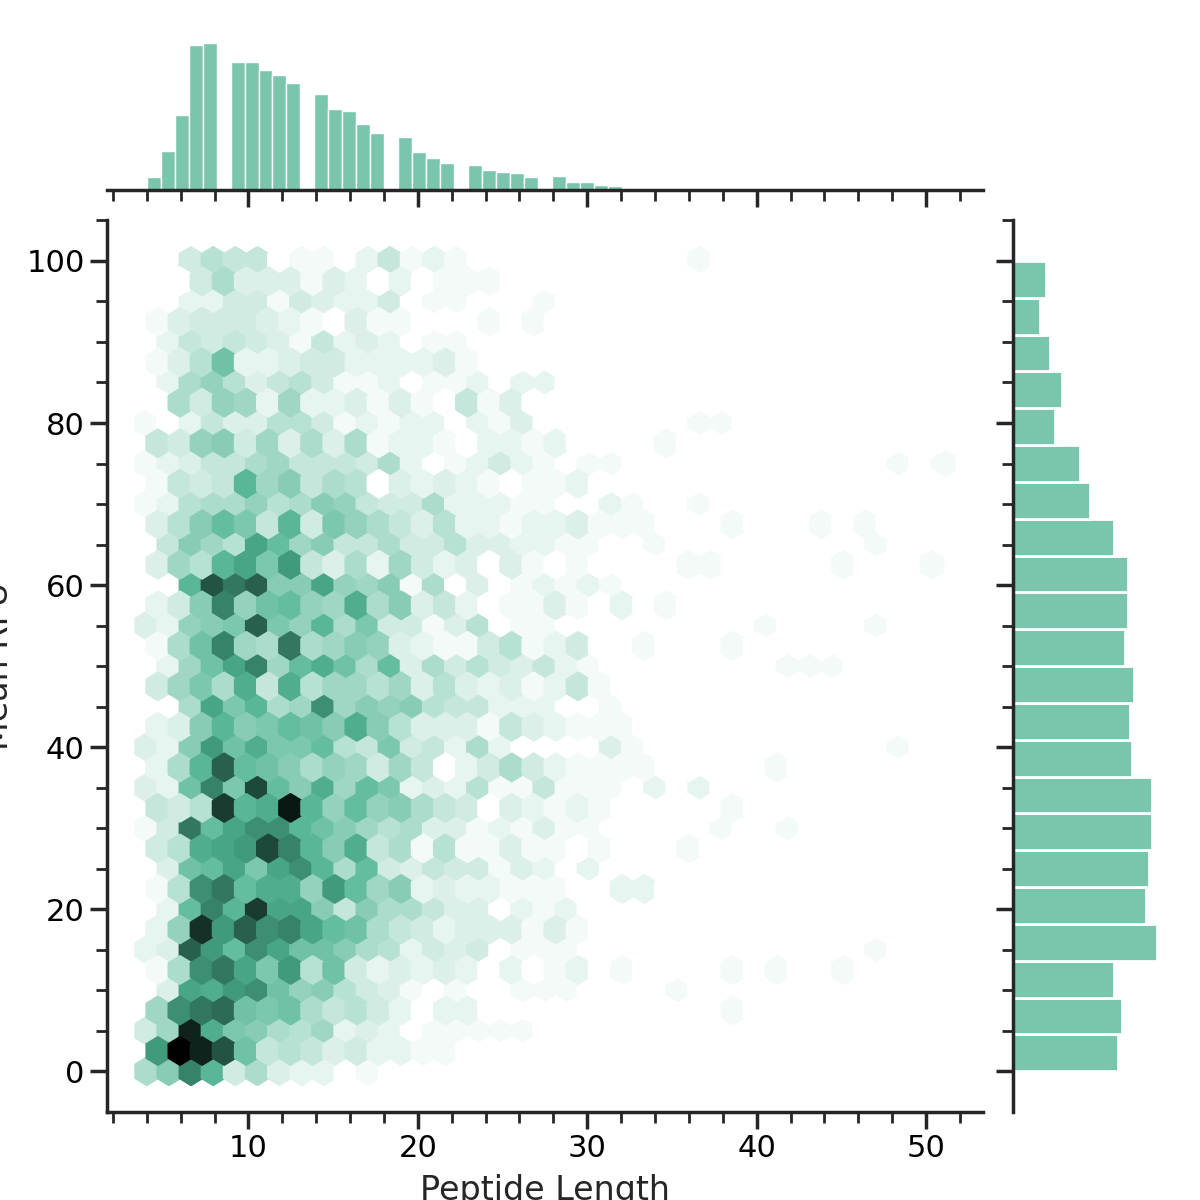

In [1]:
# plot jointplot of peptide length and mean RFU
import proplot as pplt
import pandas as pd
import numpy as np
import os   

import matplotlib.pyplot as pplt
import seaborn as sns

root_dir = f'/home/lwang/models/HDX_LSTM/data/Latest_set'
hdx_dir = f'{root_dir}/HDX_files/'
pdb_dir = f'{root_dir}/structure/'
hdxm_dir = f'{root_dir}/HDX_files/hdxm_files'

summary_df = pd.read_excel(f'/home/lwang/models/HDX_LSTM/data/Latest_set/merged_data-NAcomplex.xlsx', sheet_name='Sheet1')
summary_df = summary_df[summary_df['complex_state'].isin(['single', 'protein complex'])]
summary_df = summary_df.dropna(subset=['structure_file'])
summary_df = summary_df[summary_df['database_id'] != 'PXD041774']
check_df = summary_df.drop_duplicates(subset=['database_id'])

rfu_list = []
pepLen_list = []
for database_id in check_df['database_id'].unique():
    fname = f'{root_dir}/HDX_files/{database_id}_revised.csv'
    if not os.path.exists(fname):
        print('Missing HDX file:', database_id)
        continue
    df = pd.read_csv(fname)
    df = df[(df['log_t']>=1.35) & (df['log_t']<2.85)] # HDX middle exposure range
    grouped = df.groupby(['protein', 'state', 'sequence'])

    for (protein, state, sequence), group in grouped:
        mean_rfu = group['RFU'].mean()
        rfu_list.append(mean_rfu)
        pepLen_list.append(len(sequence))

print(len(rfu_list), len(pepLen_list))
print(np.mean(rfu_list), np.std(rfu_list))
print(np.mean(pepLen_list), np.std(pepLen_list))

sns.set_theme(style="ticks")
sns.jointplot(x=pepLen_list, y=rfu_list, kind="hex", color="#4CB391")
pplt.xlabel('Peptide Length')
pplt.ylabel('Mean RFU')
pplt.show()

In [1]:
# under environment of py3.9
import os
from tqdm import tqdm
import torch
import pandas as pd
import proplot as pplt
import matplotlib.pyplot as plt
import seaborn as sns

root_dir = "/home/lwang/models/HDX_LSTM/data/Latest_set"
pepGraph_dir = os.path.join(root_dir, 'graph_ensemble_simpleGearNet', 'cluster1_8A_manual_rescale')
summary_HDX_file = f'{root_dir}/merged_data-NAcomplex.xlsx'
hdx_df = pd.read_excel(summary_HDX_file, sheet_name='Sheet1')
hdx_df = hdx_df.dropna(subset=['structure_file'])

input = []
hdx_df = hdx_df.drop_duplicates(subset=['structure_file'])

print('data loading')
for row_id, row in tqdm(hdx_df.iterrows()):
    pdb = row['structure_file'].strip().split('.')[0].upper()
    pepGraph_file = f'{pepGraph_dir}/{pdb}.pt'
    if os.path.isfile(pepGraph_file):
        pepGraph_ensemble = torch.load(pepGraph_file)
        input.extend(pepGraph_ensemble)
    else:
        continue

RFU_list = []
graphLen_list = []
pepLen_list = []
for graph in input:
    start, end = graph.range.detach().numpy()
    RFU_list.extend(graph.y.detach().numpy().flatten())
    pepLen_list.append(end-start+1)
    graphLen_list.append(graph.num_node)

/home/lwang/models/mambaforge/envs/py3.9/lib/python3.9/site-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


data loading


154it [00:17,  8.79it/s]


11647 11647 11647


/home/lwang/models/mambaforge/envs/py3.9/lib/python3.9/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/lwang/models/mambaforge/envs/py3.9/lib/python3.9/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/lwang/models/mambaforge/envs/py3.9/lib/python3.9/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


AttributeError: module 'proplot' has no attribute 'xlabel'

11647 11647 11647


/home/lwang/models/mambaforge/envs/py3.9/lib/python3.9/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/lwang/models/mambaforge/envs/py3.9/lib/python3.9/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)
/home/lwang/models/mambaforge/envs/py3.9/lib/python3.9/site-packages/numpy/lib/arraysetops.py:733: RuntimeWarning: invalid value encountered in equal
  mask |= (ar1 == a)


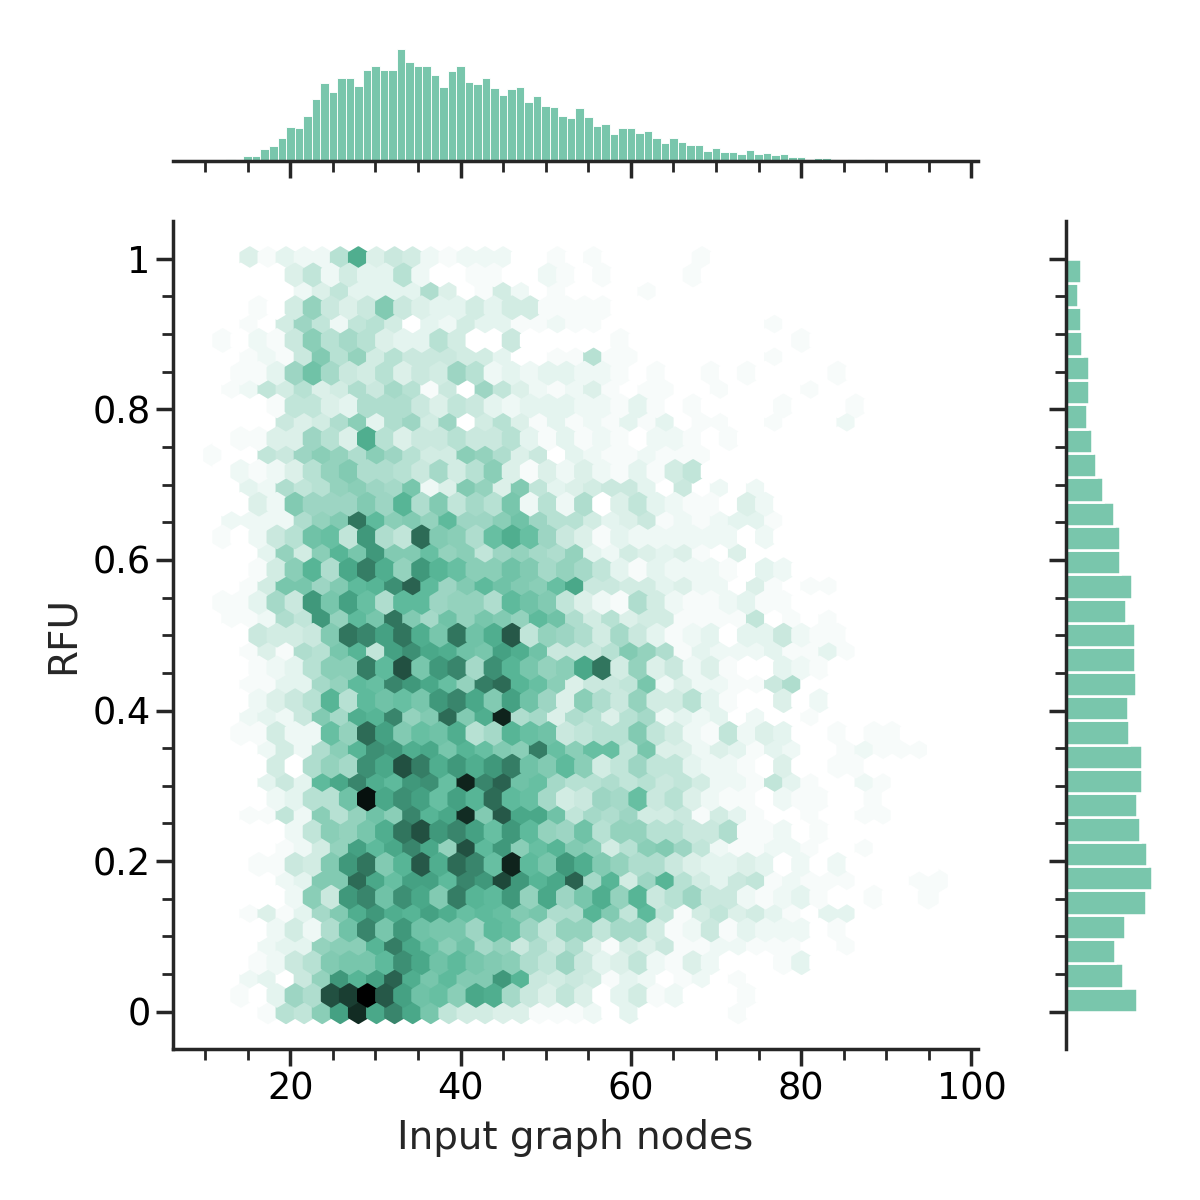

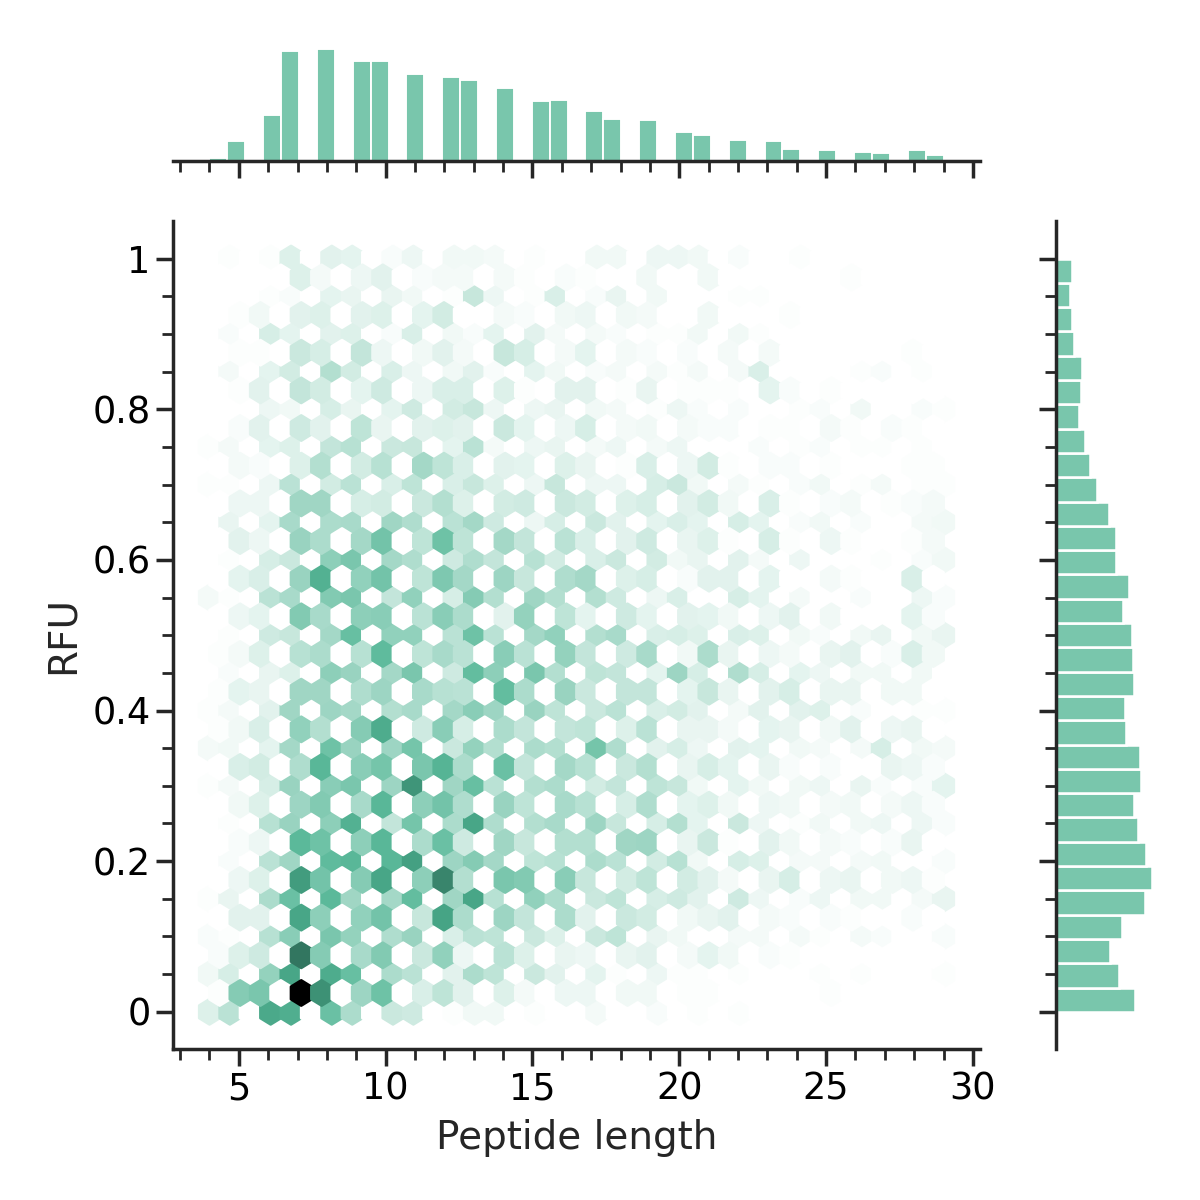

In [7]:
%matplotlib inline
print(len(RFU_list), len(pepLen_list), len(graphLen_list))
sns.set(style='ticks', rc={'figure.figsize':(14,10)})
sns.set_context("notebook", font_scale=1.2)
joint_plot = sns.jointplot(x=graphLen_list, y=RFU_list, kind="hex", color="#4CB391")
joint_plot.set_axis_labels('Input graph nodes', 'RFU', fontsize=14)
plt.tight_layout()
plt.savefig('/home/lwang/models/HDX_LSTM/results/240918_GVP/figures/GraphNodes_RFU_distribution.png', dpi=300)

sns.set(style='ticks', rc={'figure.figsize':(14,10)})
sns.set_context("notebook", font_scale=1.2)
joint_plot = sns.jointplot(x=pepLen_list, y=RFU_list, kind="hex", color="#4CB391")
joint_plot.set_axis_labels('Peptide length', 'RFU', fontsize=14)
plt.tight_layout()
plt.savefig('/home/lwang/models/HDX_LSTM/results/240918_GVP/figures/PeptideLen_RFU_distribution.png', dpi=300)

In [17]:
import numpy as np

RFU_list = np.array(RFU_list)
pepLen_list = np.array(pepLen_list)
print(RFU_list[RFU_list < 0.7].shape[0]/ RFU_list.shape[0])
mask = (pepLen_list>5) & (pepLen_list<20)
print(pepLen_list[mask].shape[0]/ pepLen_list.shape[0])

print(np.mean(RFU_list), np.std(RFU_list))
print(np.mean(pepLen_list), np.std(pepLen_list))
print(np.mean(graphLen_list), np.std(graphLen_list))

0.8797973727140036
0.8564437194127243
0.39396763 0.24245872
12.910277324632952 5.312677472360183
40.531810766721044 13.5823648791256


In [2]:
import seaborn as sns
import matplotlib.pyplot as pplt
import pickle

sns.set_theme(style="ticks")
sns.jointplot(x=pepLen_list, y=RFU_list, kind="hex", color="#4CB391")
pplt.xlabel('Peptide Length')
pplt.ylabel('Mean RFU')
pplt.show()

with open(f'/home/lwang/models/HDX_LSTM/data/Latest_set/HDX_files/res_D_fit_mean/RFU_list.pkl', 'wb') as f:
    pickle.dump(RFU_list, f)
with open(f'/home/lwang/models/HDX_LSTM/data/Latest_set/HDX_files/res_D_fit_mean/pepLen_list.pkl', 'wb') as f:
    pickle.dump(pepLen_list, f)

In [16]:
RFU_range = (0.6, 1.0)
pepLen_range = (5, 20)
N_sample = 1000

class PeptideSet:
    _registry = []
    def __init__(self, id, pep_sequence, start_pos, end_pos, rfu_value):
        self.row_id = id
        self._registry.append(self)
        self.sequence = pep_sequence
        self.chain = None
        self.start = start_pos
        self.end = end_pos
        self.rfu_value = rfu_value


def slide_window(residue_dict, row_id, window_size, sequence, RFU_range, D_conc, back_Ex=0.7, existing_peptides=[]):
    residue_ids = sorted(residue_dict.keys())
    residue_dict[-1] = -9999 #for penalty
    for key in residue_dict.keys():
        if np.isnan(residue_dict[key]):
            residue_dict[key] = -9999
    
    for i in residue_ids:
        window_uptake = sum([residue_dict[id] if id in residue_ids else -1 for id in range(i, i+window_size)])
        if window_uptake < 0: # filter out residue gaps, missing values
            continue
        pep_sequence = ''.join(sequence[i:i+window_size])
        if pep_sequence in existing_peptides or 'x' in pep_sequence:
            continue
        N_ExRes = count_ExRes(pep_sequence)
        pep_RFU = window_uptake / D_conc * N_ExRes * back_Ex
        if pep_RFU < RFU_range[0] or pep_RFU > RFU_range[1]:
            continue

        PeptideSet(
            id=row_id,
            pep_sequence=pep_sequence,
            start_pos=i,
            end_pos=i+window_size-1,
            rfu_value=pep_RFU
        )
    
for res_d_file in os.listdir(f'{root_dir}/HDX_files/res_D_fit_mean'):
    if not res_d_file.endswith('.pkl'):
        continue
    file_id = int(res_d_file.split('.')[0])
    if not os.path.exists(f'{root_dir}/HDX_files/hdxm_files/{file_id}.csv'):
        continue
    if not os.path.exists(f'{root_dir}/HDX_files/res_D_fit_mean/{file_id}.pkl'):
        continue
    with open(f'{root_dir}/HDX_files/res_D_fit_mean/{file_id}.pkl', 'rb') as f:
        res_D_dict = pickle.load(f)

    for length in range(pepLen_range[0], pepLen_range[1]+1):
        row = summary_df.loc[file_id]
        D_conc = row['D_Conc']

        df = csv_to_dataframe(f'{root_dir}/HDX_files/hdxm_files/{file_id}.csv')
        existing_peptides = list(df['_sequence'].unique())
        sequence = df.attrs["metadata"]['sequence']
        slide_window(res_D_dict, file_id, length, sequence, RFU_range, D_conc, back_Ex=0.7, existing_peptides=existing_peptides)


In [20]:
peptide_data = []

# Collect peptide information
for peptide in PeptideSet._registry:
    row = summary_df.loc[peptide.row_id]
    peptide_data.append({
        'start': peptide.start,
        'end': peptide.end,
        'sequence': peptide.sequence,
        'RFU': peptide.rfu_value * 100,
        'protein': row['protein'],
        'state': row['state'],
        'database_id': 'Extend_data',
        'maxD': count_ExRes(peptide.sequence),
        'log_t': 2.0
    })

extend_hdx_df = pd.DataFrame.from_records(peptide_data)

# Filter `summary_df` only once
extend_summary_df = summary_df.loc[[peptide.row_id for peptide in PeptideSet._registry]].copy()
extend_summary_df = extend_summary_df.drop_duplicates(subset=['protein', 'state'])
extend_summary_df['database_id'] = 'Extend_data'

# Save to Excel files
extend_hdx_df.to_excel(f'{root_dir}/HDX_files/Extend_data_revised.xlsx', index=False, sheet_name='Sheet1', engine='openpyxl')
extend_summary_df.to_excel(f'{root_dir}/Extend_summary.xlsx', index=False, sheet_name='Sheet1', engine='openpyxl')

PeptideSet registry: 3214


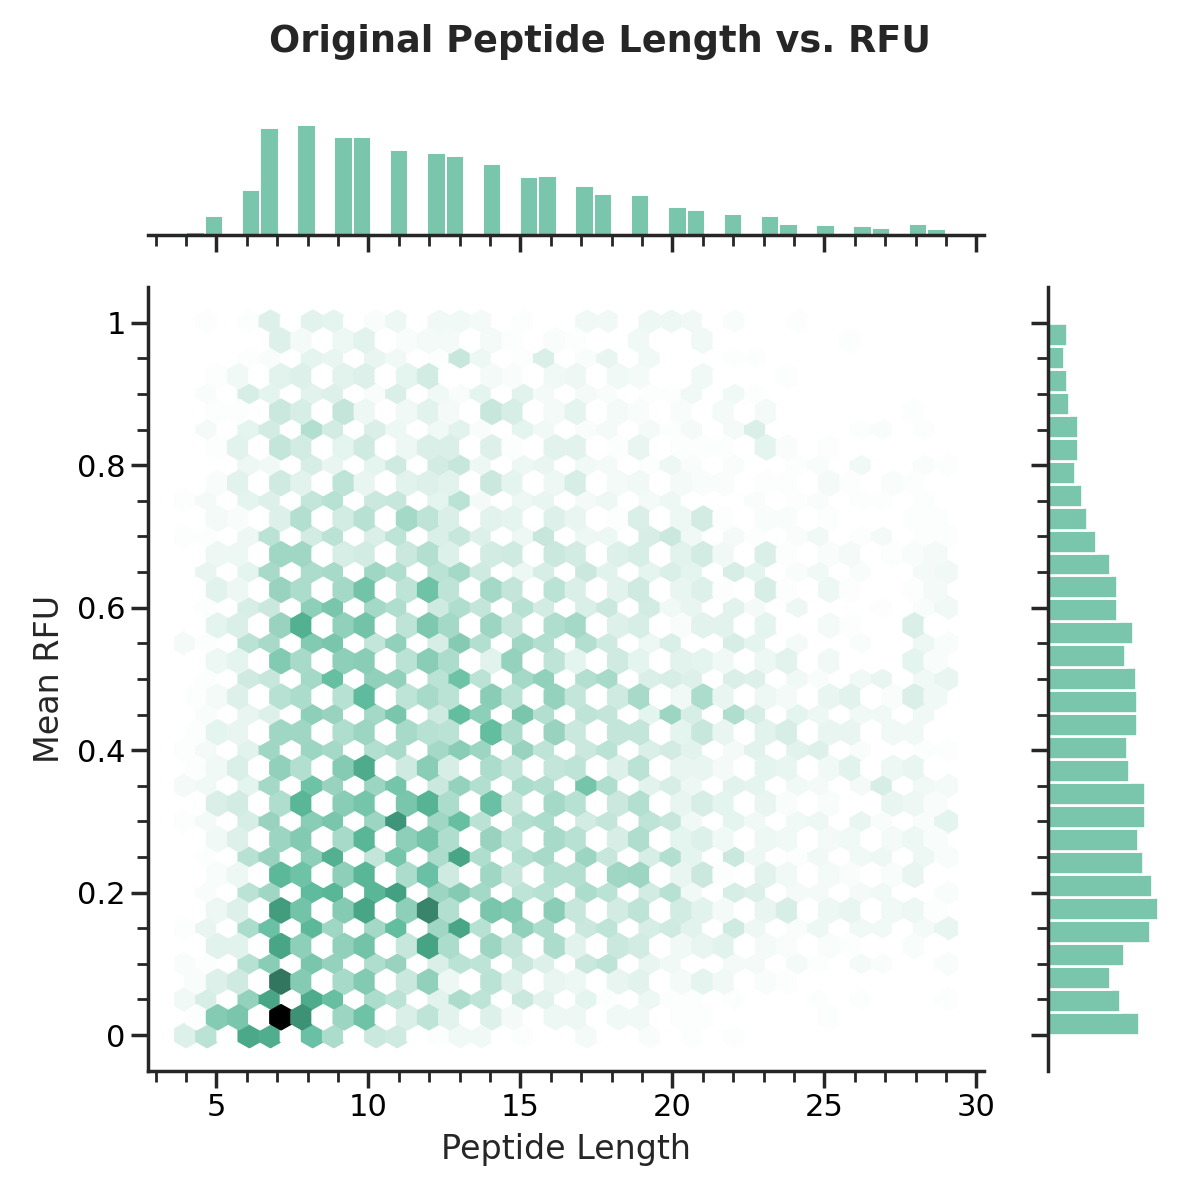

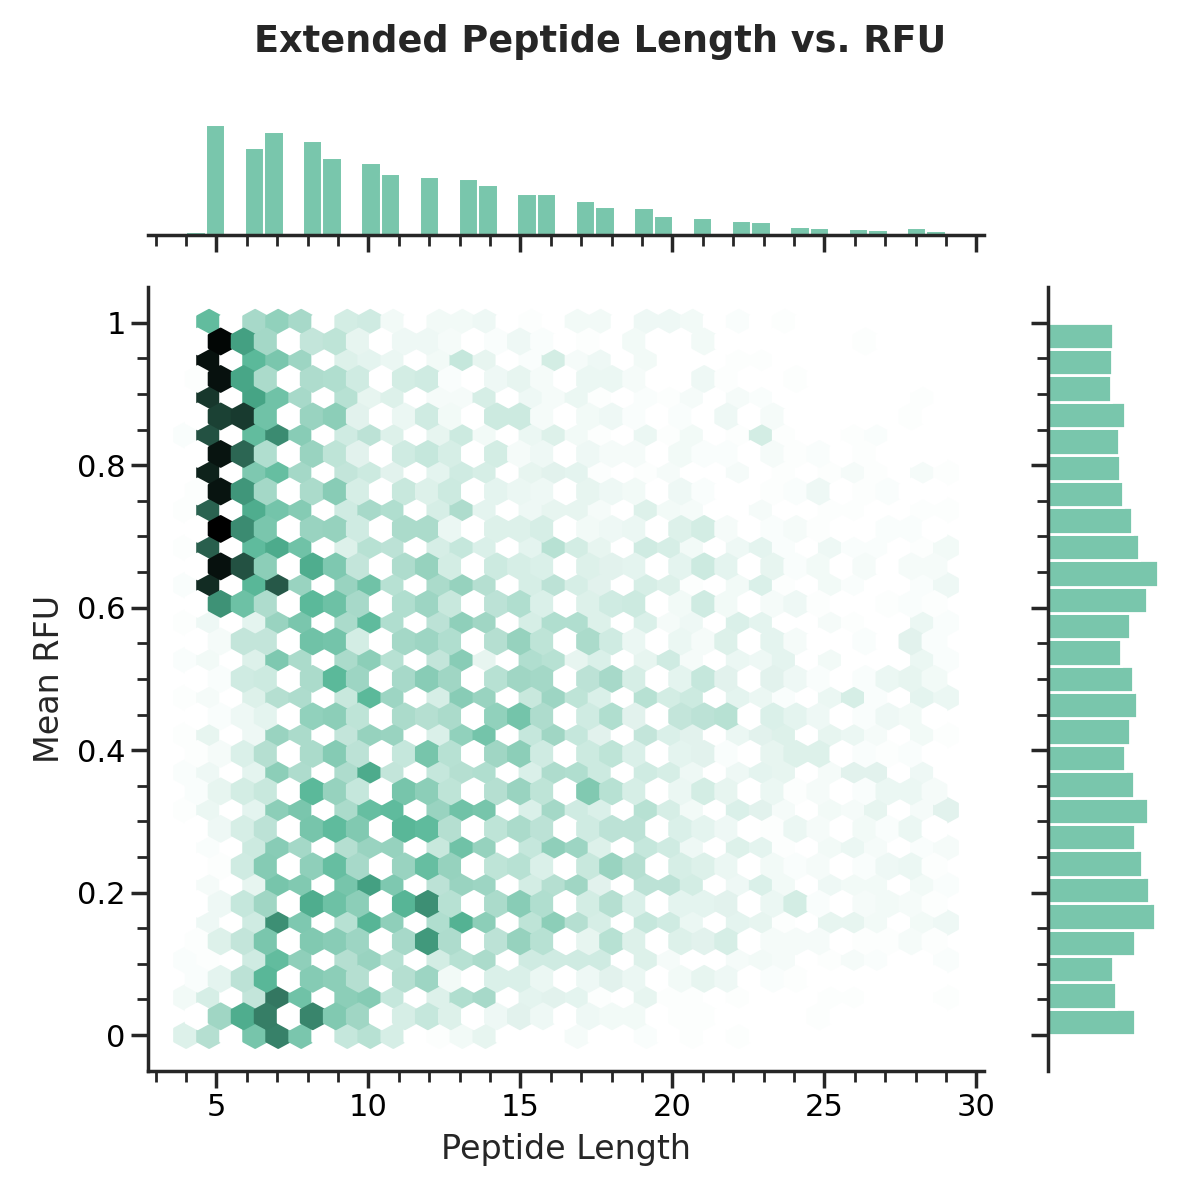

In [17]:
print('PeptideSet registry:', len(PeptideSet._registry))

pepLen_list = []
RFU_list = []
with open(f'{root_dir}/HDX_files/RFU_list.pkl', 'rb') as f:
    RFU_list = pickle.load(f)
with open(f'{root_dir}/HDX_files/pepLen_list.pkl', 'rb') as f:
    pepLen_list = pickle.load(f)

Extend_pepLen_list = []
Extend_RFU_list = []
for peptide in PeptideSet._registry:
    Extend_pepLen_list.append(len(peptide.sequence))
    Extend_RFU_list.append(peptide.rfu_value)
    #print(peptide.sequence, peptide.start, peptide.end, peptide.hdx_value)

sns.set_theme(style="ticks")
# First jointplot
g1 = sns.jointplot(x=pepLen_list, y=RFU_list, kind="hex", color='#4CB391')
g1.set_axis_labels('Peptide Length', 'Mean RFU')
g1.fig.suptitle('Original Peptide Length vs. RFU')
g1.fig.tight_layout()  # Adjust layout to prevent overlap with title
g1.fig.subplots_adjust(top=0.9)  # Manually adjust space for the title

# Second jointplot
g2 = sns.jointplot(x=pepLen_list + Extend_pepLen_list, y=RFU_list + Extend_RFU_list, kind="hex", color='#4CB391')
g2.set_axis_labels('Peptide Length', 'Mean RFU')
g2.fig.suptitle('Extended Peptide Length vs. RFU')
g2.fig.tight_layout()
g2.fig.subplots_adjust(top=0.9)

# Show the plots
pplt.show()